In [281]:
import numpy as np
import cv2

from scipy import stats

%matplotlib inline
from matplotlib import pyplot as plt

In [284]:
#im = cv2.imread('../data/sports.jpg')
#im = cv2.imread('../data/lightson.jpg', flags=cv2.IMREAD_COLOR)
#im = cv2.imread('../data/allon.jpg', flags=cv2.IMREAD_COLOR)
#im = cv2.imread('../data/allon_lightson.jpg')

# zones 1 and 3 on
im = cv2.imread('../data/dump/hvac/statechange/2019-02-22_12-28-59.jpg.jpg')

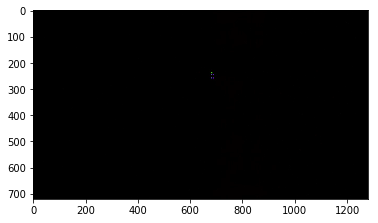

In [285]:
plt.imshow(im)

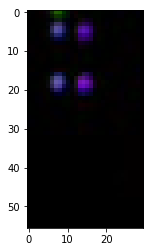

In [287]:
#
# Crop an ROI -- hardcode for now!
#
im_roi = im[200:296,675:705]
plt.imshow(im_roi)

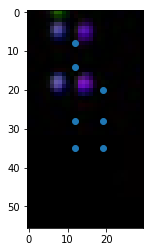

In [288]:
led_centroids = np.array(
    [[8,12],
     [14,12],
     [20,19],
     [28,12],
     [28,19],
     [35,12],
     [35,19]])
plt.imshow(im_roi)
plt.scatter(led_centroids[:,1], led_centroids[:,0])

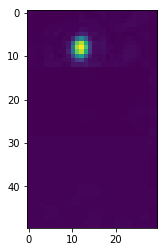

In [258]:
im_hsv = cv2.cvtColor(im_roi, cv2.COLOR_BGR2HSV)

plt.imshow(im_hsv[:,:,2])

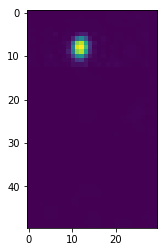

In [259]:
im_roi_gray = cv2.cvtColor(im_roi, cv2.COLOR_BGR2GRAY)
plt.imshow(im_roi_gray)

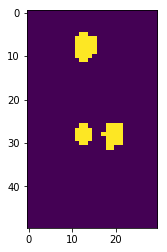

In [220]:
plt.imshow(im_roi_gray > 20)

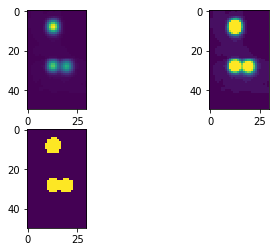

In [230]:
b = cv2.GaussianBlur(im_roi_gray, (5,5), 3, 3)

plt.subplot(2,2,1)
plt.imshow(b)

c = cv2.addWeighted(b, 10, b, 0, 0)
plt.subplot(2,2,2)
plt.imshow(c)

mask = c > 128
plt.subplot(2,2,3)
plt.imshow(mask)

In [231]:
total_mask = mask.astype(np.uint8) * 255

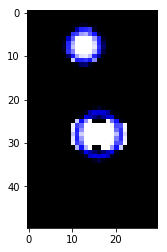

In [232]:
params = cv2.SimpleBlobDetector_Params()
params.minThreshold = 0
params.maxThreshold = 400
params.minDistBetweenBlobs = 1
params.filterByArea = True
params.minArea = 0
params.maxArea = 100
params.filterByCircularity = False
params.filterByConvexity = False
params.filterByInertia = False
params.filterByColor = False

detector = cv2.SimpleBlobDetector_create(params)
keypoints = detector.detect((total_mask.astype(np.uint8)))

im_with_keypoints = cv2.drawKeypoints(total_mask, keypoints, np.array([]), (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(im_with_keypoints)
#plt.imshow(total_mask)

In [201]:
keypoints

[<KeyPoint 000001AA008CBF60>]

In [202]:
pts = np.asarray([[p.pt[1], p.pt[0]] for p in keypoints])
pts

len(pts)

1

In [203]:
np.sort(pts, axis=0)

array([[ 6.84848499, 12.5       ]])